Before starting to work we have to import the following library, pay attention that **crossentropy**, **sequence** and **unet** have to uploaded in the notebook. You can find them in notebooks/utility/  .

In [ ]:
!pip install tensorflow_addons

from tensorflow.keras.utils import Sequence
import tensorflow as tf
import json
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.losses import Loss
from sklearn.utils import shuffle
import math
from crossentropy import MyCrossentropy 
from sequence import FoodSequence
from unet import UNet

from google.colab import drive
drive.mount('/content/drive/')

     |████████████████████████████████| 686kB 7.4MB/s 


Data set downloading

In [ ]:
!pip install -U aicrowd-cli
API_KEY = "67587f4b3488144e75864045bf9db5e9" #get your api-key from https://www.aicrowd.com/participants/me

!aicrowd login --api-key $API_KEY 

!aicrowd dataset download --challenge food-recognition-challenge 3 4 5
!tar -zxvf train-v0.4.tar.gz

In [ ]:
print('Loading UNet model')
model = tf.keras.models.load_model('/content/drive/My Drive/Food recognition challenge/models/unet/architecture', custom_objects={"UNet": UNet}, compile=False)
print('Model loaded')

In [ ]:
loading_path = '/content/drive/My Drive/Food recognition challenge/models/unet/weights/unet_weights_epoch100.h5'
print('Loading weights of epoch',  loading_path[-5:-3])
model.load_weights(loading_path)
print('Weights loaded')

In [ ]:
def precision(mask, y_pred, threshold=0.6):
  y = y_pred > threshold
  real_cats = tf.math.reduce_any(tf.cast(mask, dtype=tf.bool), axis=[1, 2])
  cats = tf.math.reduce_any(y, axis=[1, 2])
  true_positive = tf.math.count_nonzero(tf.boolean_mask(real_cats, cats))
  tp_plus_fp = tf.math.count_nonzero(cats)
  if tp_plus_fp == 0:
    return tf.cast(0, dtype=tf.float64);
  return true_positive / tp_plus_fp

In [ ]:
def IoU(mask, y_pred, threshold=0.6):
  y = y_pred > threshold
  intersection = tf.math.count_nonzero(tf.boolean_mask(y, mask))
  union = tf.math.count_nonzero(mask + tf.cast(y, dtype=tf.float32))
  return  intersection / union

In [ ]:
def precisionWithIoU(mask, y_pred, threshold_max=0.79, threshold=0.41):
  y_max = y_pred > threshold_max
  y = y_pred > threshold 
  real_cats = tf.math.reduce_any(tf.cast(mask, dtype=tf.bool), axis=[1, 2])
  cats = tf.math.reduce_any(y_max, axis=[1, 2])
  number_of_prediction = tf.math.count_nonzero(cats)
  if number_of_prediction == 0:
    return tf.cast(0, dtype=tf.float64)

  intersections = tf.math.count_nonzero(tf.logical_and(tf.cast(mask, dtype=tf.bool), y), axis=[1, 2])
  unions = tf.math.count_nonzero(tf.logical_or(tf.cast(mask, dtype=tf.bool), y), axis=[1, 2])
  ious = intersections / unions
  predicted_cats = tf.logical_and(ious > 0.5, cats)
  true_positive = tf.math.count_nonzero(tf.logical_and(real_cats, predicted_cats))

  return true_positive / number_of_prediction

In [ ]:
file = open("train/annotations.json", "r")
annotations = json.loads(file.read())

ann = pd.DataFrame(annotations['annotations'])
mapping = {item:i for i, item in enumerate(ann["category_id"].unique())}
categories = pd.DataFrame(annotations['categories'])
categories['id'] = categories['id'].apply(lambda x: mapping[x])
categories = categories.set_index('id')

file_ = open("val/annotations.json", "r")
annotations = json.loads(file_.read())

ann = pd.DataFrame(annotations['annotations'])
ann["category_id"] = ann["category_id"].apply(lambda x: mapping[x])
annotations_map = {img_id: {} for img_id in ann['image_id'].unique()}
for index, row in ann.iterrows():
    annotations_map[row['image_id']][row['category_id']] = row['segmentation']
images = pd.DataFrame(annotations['images'])
images = images.set_index('id')

np.random.seed(0)
msk = np.random.rand(len(images)) < 0.5
val_images = images[msk]
test_images = images[~msk]

val_set = FoodSequence(val_images, annotations_map, len(categories), batch_size=1, folder='val',img_size=(256, 256), data_augmentation=False)

In [ ]:
from functools import partial

ths = [0.405, 0.410, 0.415, 0.420, 0.425, 0.430, 0.435]
ious = []

for threshold in ths:
  model.compile(metrics=partial(precisionWithIoU, threshold=threshold))
  results = model.evaluate(val_set)
  ious.append(results[1])

649/649 [==============================] - 55s 84ms/step - loss: 0.0000e+00 - partial: 0.1126


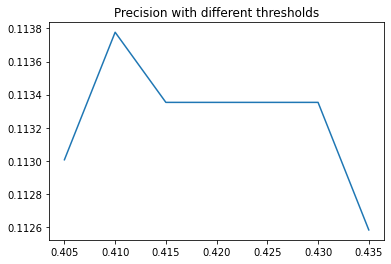

In [ ]:
plt.plot(ths, ious);
plt.title("Precision with different thresholds");

In [ ]:
def desired_output(img_shape, segmentations):
        desired_output = np.zeros((img_shape[0], img_shape[1], len(categories)), dtype=np.int32)

        for i in segmentations:
          t = np.zeros((img_shape[0], img_shape[1], 1), dtype=np.int32)
          for seg in segmentations[i]:
              s = np.array(seg, dtype=np.int32).reshape((-1, 2))
              t = cv2.fillPoly(t, [s], 255)

          desired_output[:, :, i] = t.squeeze()

        return desired_output / 255

In [ ]:
threshold = 0.58
img_id = val_images.sample().index.values[0]
print("Sample n°", img_id)
img = cv2.imread('val/images/' + val_images.loc[img_id, 'file_name'])

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

input_img = cv2.resize(img, dsize=(256, 256)) / 255
y = model.predict(input_img.reshape((1, input_img.shape[0], input_img.shape[1], input_img.shape[2])))

img_ann = ann[ann['image_id'] == img_id]
segmentations = dict(zip(img_ann['category_id'], img_ann['segmentation']))
y_true = desired_output(img.shape, segmentations)
y_true = cv2.resize(y_true, dsize=(256, 256), interpolation=cv2.INTER_NEAREST)

print("IoU: ", IoU(y_true, y[0], threshold=threshold))

y = y > threshold
for i in range(len(categories)):
  if np.any(y[0, :, :, i]):
    fig = plt.figure()
    plt.title(categories.iloc[i]['name'] + " - max " + str(np.max(y[0, :, :, i])))
    plt.imshow(y[0, :, :, i], cmap='gray', vmin=0, vmax=1)

In [ ]:
def true_positive(mask, y_pred, threshold_max=0.79, threshold=0.41):
  y_max = y_pred > threshold_max
  y = y_pred > threshold 
  real_cats = tf.math.reduce_any(tf.cast(mask, dtype=tf.bool), axis=[1, 2])
  cats = tf.math.reduce_any(y_max, axis=[1, 2])

  intersections = tf.math.count_nonzero(tf.logical_and(tf.cast(mask, dtype=tf.bool), y), axis=[1, 2])
  unions = tf.math.count_nonzero(tf.logical_or(tf.cast(mask, dtype=tf.bool), y), axis=[1, 2])
  ious = intersections / unions
  predicted_cats = tf.logical_and(ious > 0.5, cats)

  return tf.math.count_nonzero(tf.logical_and(real_cats, predicted_cats))

def true_negative(mask, y_pred, threshold_max=0.79, threshold=0.41):
  y_max = y_pred > threshold_max
  real_cats = tf.math.reduce_any(tf.cast(mask, dtype=tf.bool), axis=[1, 2])
  cats = tf.math.reduce_any(y_max, axis=[1, 2])
  true_negative_chan = tf.logical_not(tf.logical_or(cats, real_cats))
  return tf.math.count_nonzero(true_negative_chan)

def false_positive(mask, y_pred, threshold_max=0.79, threshold=0.41):
  y_max = y_pred > threshold_max
  cats = tf.math.reduce_any(y_max, axis=[1, 2])
  return tf.math.count_nonzero(cats) - true_positive(mask, y_pred, threshold_max, threshold)

def false_negative(mask, y_pred, threshold_max=0.79, threshold=0.41):
  y_max = y_pred > threshold_max
  cats = tf.math.reduce_any(y_max, axis=[1, 2])
  return tf.math.count_nonzero(tf.logical_not(cats)) - true_negative(mask, y_pred, threshold_max, threshold)

In [ ]:
test_set = FoodSequence(test_images, annotations_map, len(categories), batch_size=1, folder='val',img_size=(256, 256), data_augmentation=False)

In [ ]:
model.compile(metrics=[true_positive, true_negative, false_positive, false_negative])
model.evaluate(test_set)